<a href="https://colab.research.google.com/github/nunocesarsa/GoogleColab_public/blob/master/GP_Augmentation_OVPGrass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Try again with data from a single acquisition

Loading drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing packages

In [3]:
#General purpose: 
#plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#data management
import pandas as pd
import numpy
import numpy as np

#Gaussian processes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

#model evaluation from sklearn
from sklearn import metrics

#a few more stuff for random
import random as rdm
import math

Generating a GP model call that is customizable. This helps to create more lean loops but is somewhat unecessary.

In [14]:
#gaussian processes with default acquisition function
#initializing the gaussian process -optimized
K_ratQ = RationalQuadratic(length_scale_bounds="fixed",alpha_bounds="fixed")
K_RBF = RBF(length_scale_bounds="fixed")

def gpr_call():
  mdl = GaussianProcessRegressor(kernel=K_ratQ,
                                 n_restarts_optimizer=80, # -> 1*RBF(1.0) is the default kernel
                                 normalize_y=True,
                                 alpha=.05)
#with 0 alpha, crazy results

                                 #alpha=.001)
                                 #alpha=.05)
  return mdl
  

Loading the csv file

In [92]:
#filepath="/content/drive/My Drive/Leon/Leon_Data_Montesinho.csv"
filepath="/content/drive/My Drive/OVP_Grass/Table_data/Vincent/input_data.csv"

#for portuguese type CSV
#field_data = pd.read_csv(filepath,sep=";",decimal=",")
#for other types
field_data = pd.read_csv(filepath,sep=",",decimal=".")
#field_data

Removing NA values

In [93]:
corr_df = field_data.dropna()
print(field_data.shape)
print(corr_df.shape)

field_data=corr_df


(1607, 20)
(1576, 20)


Selecting target and explanatory variables

In [94]:
tgt_trait= "Grass height"
tgt_trait_2 = "Grass cover"

#selecting the trait and indices only
sel_df = field_data[[tgt_trait,tgt_trait_2,
                     "NDVI","EVI","RATIO",
                     "SAVI","TVI","NDWI",
                     "NDTI","RDVI","BLUE",
                     "GREEN","RED","NIR",
                     "MIR","SWIR2"]]
                  
#sel_df


Creating a 70/30 partition - NOT K-fold validation

In [95]:
#generating an index to randomly select n rows. 
index = list(range(len(sel_df)))
index30 = rdm.sample(index,math.ceil(len(index)*.3)) #randomly selects 10% of te data (aproximately)
index70 = [x for x in index if x not in index30] #makes a list with the remaining
#index90
#index10

#subsetting the pd frames
tr_df = sel_df.iloc[index70,:]
vl_df = sel_df.iloc[index30,:]

#listing all items
feat_names = list(sel_df.columns)[2:]
tgt_names = list(sel_df.columns)[:2]

Looping

------------------------------------------------------------
Trained using: NDVI
MAE hgt: 2.7137267797696563


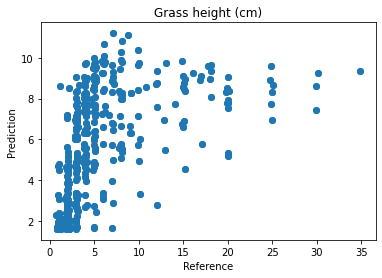

MAE cvr: 0.10293655501420203


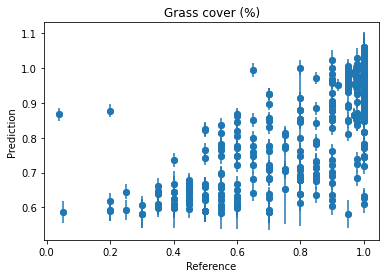

------------------------------------------------------------
------------------------------------------------------------
Trained using: EVI
MAE hgt: 2.7472708950191946


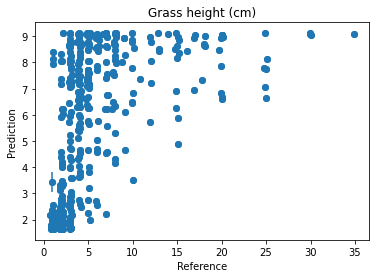

MAE cvr: 0.0910043956612855


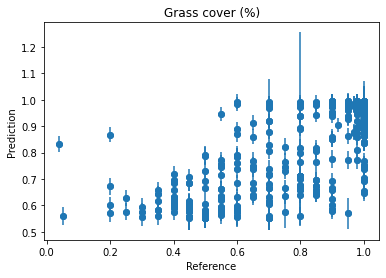

------------------------------------------------------------
------------------------------------------------------------
Trained using: RATIO
MAE hgt: 2.7342923291786425


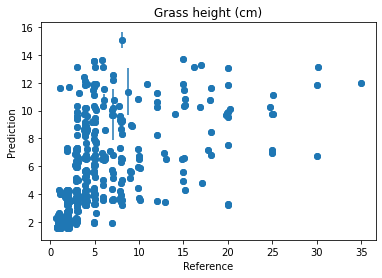

MAE cvr: 0.09165641355543318


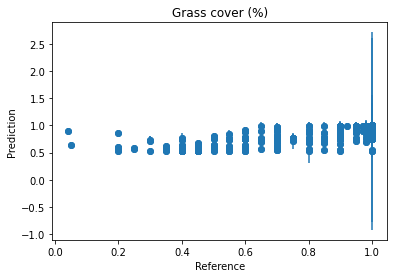

------------------------------------------------------------
------------------------------------------------------------
Trained using: SAVI
MAE hgt: 2.6990144910698537


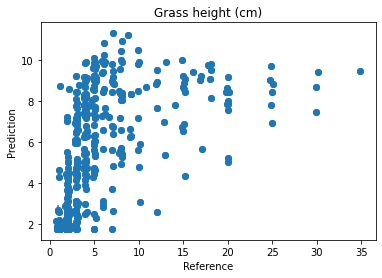

MAE cvr: 0.09656395358112349


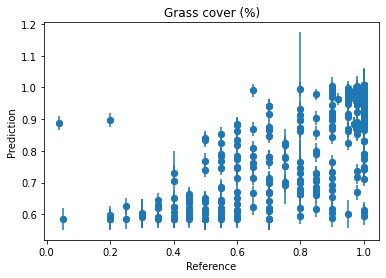

------------------------------------------------------------
------------------------------------------------------------
Trained using: TVI
MAE hgt: 2.7751613706988123


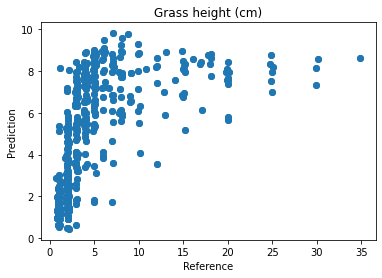

MAE cvr: 0.10691864471393385


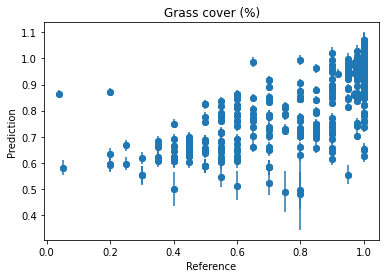

------------------------------------------------------------
------------------------------------------------------------
Trained using: NDWI
MAE hgt: 2.9216655960977604


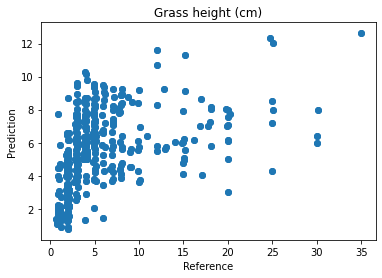

MAE cvr: 0.1254260246818947


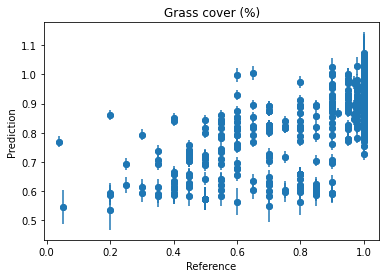

------------------------------------------------------------
------------------------------------------------------------
Trained using: NDTI
MAE hgt: 2.731093606331399


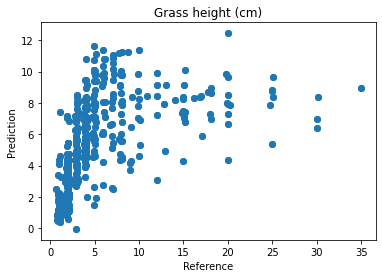

MAE cvr: 0.12015031091853888


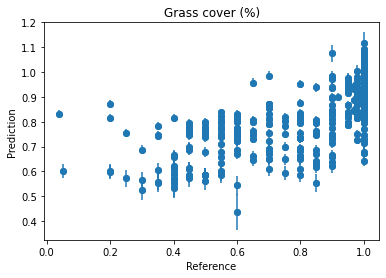

------------------------------------------------------------
------------------------------------------------------------
Trained using: RDVI
MAE hgt: 3.0693789868523162


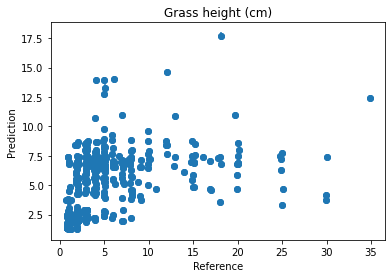

MAE cvr: 0.10497302128394334


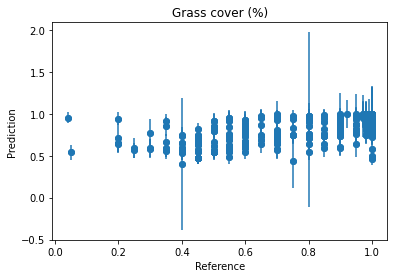

------------------------------------------------------------
------------------------------------------------------------
Trained using: BLUE
MAE hgt: 3.377033846837445


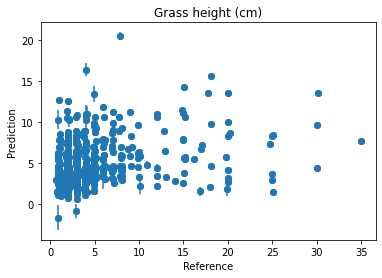

MAE cvr: 0.1746095031001748


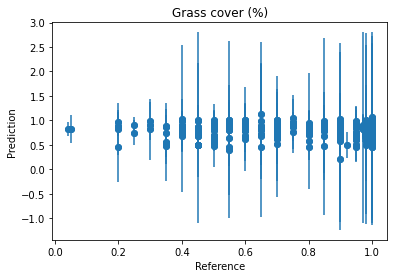

------------------------------------------------------------
------------------------------------------------------------
Trained using: GREEN
MAE hgt: 3.0085682356359356


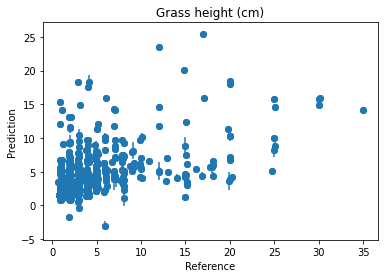

MAE cvr: 0.14723390825760388


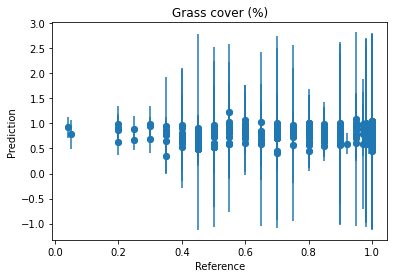

------------------------------------------------------------
------------------------------------------------------------
Trained using: RED
MAE hgt: 3.2176608579265205


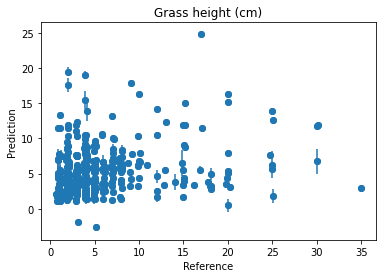

MAE cvr: 0.15212975106955776


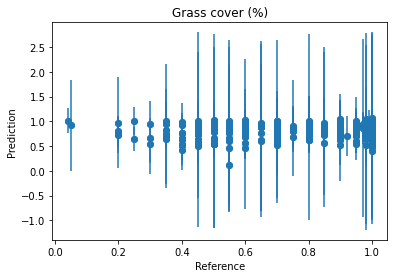

------------------------------------------------------------
------------------------------------------------------------
Trained using: NIR
MAE hgt: 3.8183029248755935


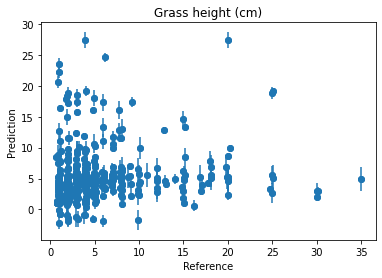

MAE cvr: 0.1570168985605993


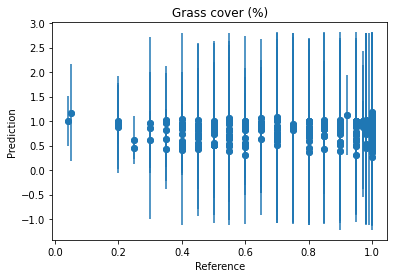

------------------------------------------------------------
------------------------------------------------------------
Trained using: MIR
MAE hgt: 3.4308243957031377


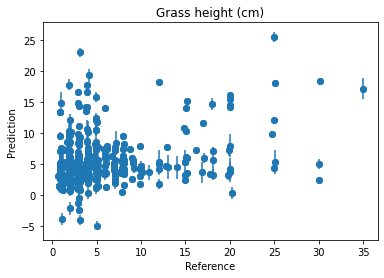

MAE cvr: 0.15068503485581086


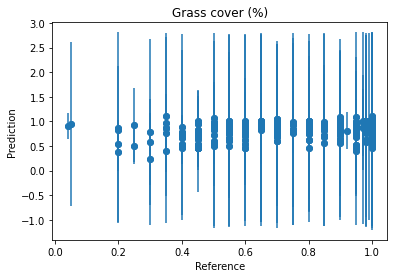

------------------------------------------------------------
------------------------------------------------------------
Trained using: SWIR2
MAE hgt: 3.116457582096757


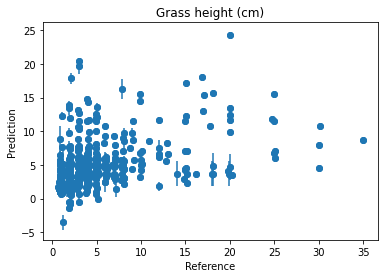

MAE cvr: 0.15491839330638202


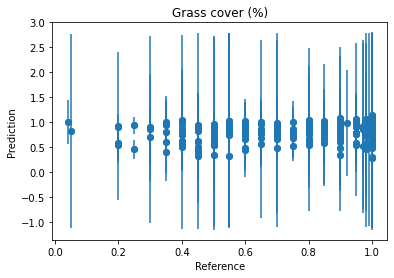

------------------------------------------------------------


In [96]:

#making a numpy of the target variables (validation)
vl_tgt_df = vl_df[[tgt_trait,tgt_trait_2]]
vl_tgt_np = vl_tgt_df.iloc[:,:].values

#making a numpy of the target variables (training)
tr_tgt_df = tr_df[[tgt_trait,tgt_trait_2]]
tr_tgt_np = tr_tgt_df.iloc[:,:].values

for i in feat_names:

  #selecting the feature used for fitting
  var_tmp_df = tr_df[[i]]

  #tranforming to numpy array
  var_tmp_np = var_tmp_df.iloc[:,:].values
  
  #initating the GP
  gpr_mdl = gpr_call()

  #training the GPR
  gpr_mdl.fit(var_tmp_np,tr_tgt_np) #trains on ith variable against the training targets

  #selecting feature on the validation dataset and transforming to numpy 
  vl_var_df = vl_df[[i]]
  vl_var_np = vl_var_df.iloc[:,:].values

  #predicting against the validation data
  pred,sigma = gpr_mdl.predict(vl_var_np,return_std=True) #predicts on the validation dataset

  #the first column is height while the second is cover
  mae_hgt = metrics.mean_absolute_error(vl_tgt_np[:,0], pred[:,0])
  mae_cvr = metrics.mean_absolute_error(vl_tgt_np[:,1], pred[:,1])

  #dumping the outputs to the console
  print("------------------------------------------------------------")
  print("Trained using:",i)
  print("MAE hgt:",mae_hgt)
  #plotting height scatterplot
  plt.scatter(vl_tgt_np[:,0], pred[:,0])
  plt.errorbar(vl_tgt_np[:,0],pred[:,0],yerr=1.96*sigma,fmt='o')
  plt.title("Grass height (cm)")
  plt.xlabel("Reference")
  plt.ylabel("Prediction")

  # R = np.corrcoef(vl_tgt_np[:,0],pred[:,0])
  # P = np.polyfit(vl_tgt_np[:,0],pred[:,0],1)
  # vmin = np.nanmin([np.min(vl_tgt_np[:,0]), np.min(pred[:,0])])
  # vmax = np.nanmax([np.max(vl_tgt_np[:,0]), np.max(pred[:,0])])
  plt.show()

  print("MAE cvr:",mae_cvr)

  plt.scatter(vl_tgt_np[:,1], pred[:,1])
  plt.errorbar(vl_tgt_np[:,1],pred[:,1],yerr=1.96*sigma,fmt='o')
  plt.title("Grass cover (%)")
  plt.xlabel("Reference")
  plt.ylabel("Prediction")
  
  # R = np.corrcoef(vl_tgt_np[:,1],pred[:,1])
  # P = np.polyfit(vl_tgt_np[:,1],pred[:,1],1)
  # vmin = np.nanmin([np.min(vl_tgt_np[:,1]), np.min(pred[:,1])])
  # vmax = np.nanmax([np.max(vl_tgt_np[:,1]), np.max(pred[:,1])])
  plt.show()
  print("------------------------------------------------------------")


 


Same as above but single target instead of multi target

------------------------------------------------------------
Trained using: NDVI
MAE hgt: 3.5446442816082904


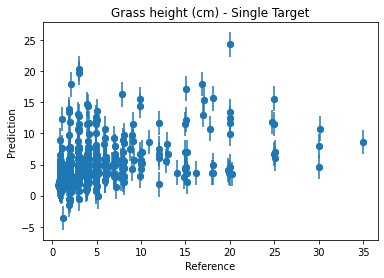

MAE cvr: 4.318678600340999


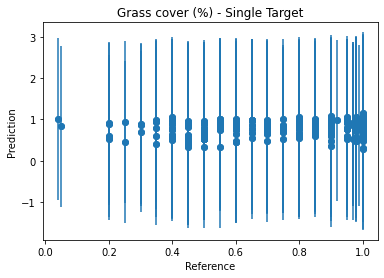

------------------------------------------------------------
------------------------------------------------------------
Trained using: EVI
MAE hgt: 3.5443766990816146


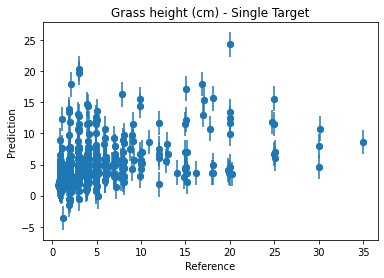

MAE cvr: 4.317857602101589


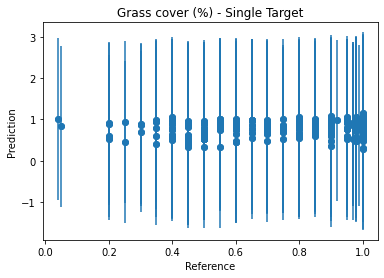

------------------------------------------------------------
------------------------------------------------------------
Trained using: RATIO
MAE hgt: 3.5451336691722046


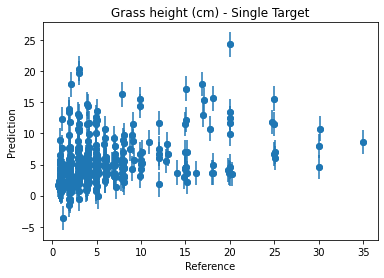

MAE cvr: 4.310262362576626


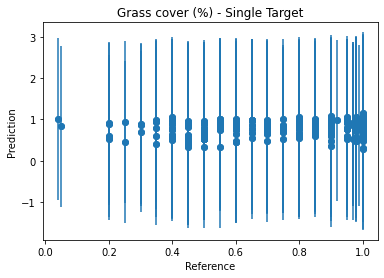

------------------------------------------------------------
------------------------------------------------------------
Trained using: SAVI
MAE hgt: 3.544565003734861


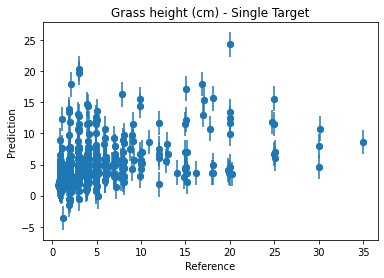

MAE cvr: 4.318462813567918


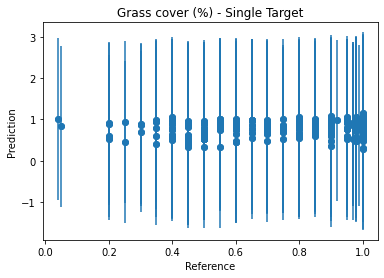

------------------------------------------------------------
------------------------------------------------------------
Trained using: TVI
MAE hgt: 3.5444970056708787


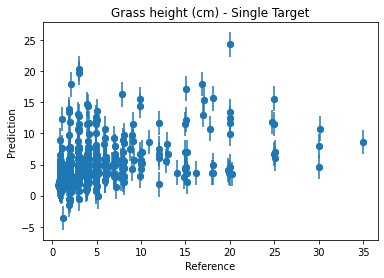

MAE cvr: 4.318412537175987


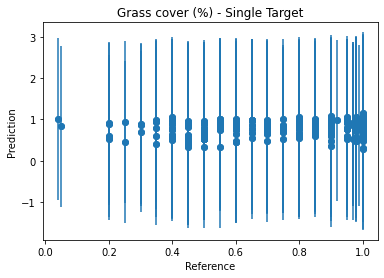

------------------------------------------------------------
------------------------------------------------------------
Trained using: NDWI
MAE hgt: 3.5447541995714067


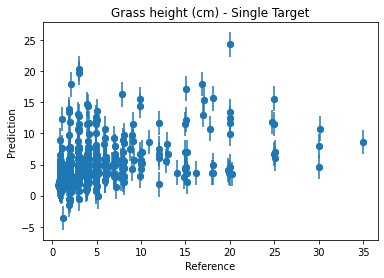

MAE cvr: 4.318939892913069


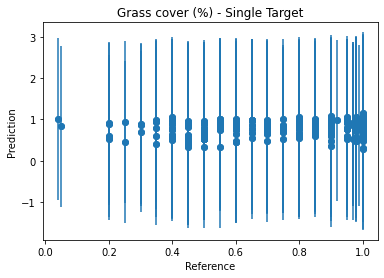

------------------------------------------------------------
------------------------------------------------------------
Trained using: NDTI
MAE hgt: 3.544723420297812


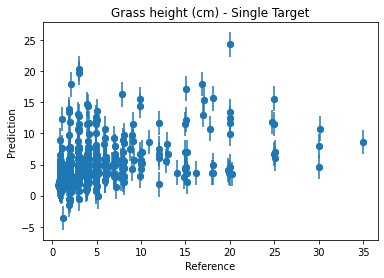

MAE cvr: 4.318886765584075


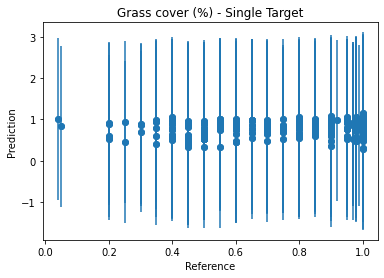

------------------------------------------------------------
------------------------------------------------------------
Trained using: RDVI
MAE hgt: 3.5608059004820776


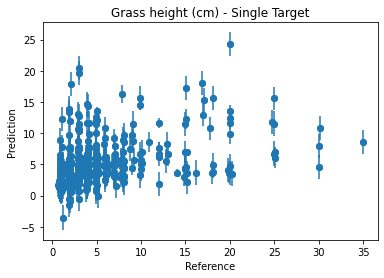

MAE cvr: 4.008218858799516


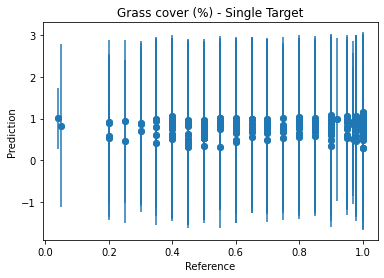

------------------------------------------------------------
------------------------------------------------------------
Trained using: BLUE
MAE hgt: 4.716605934090831


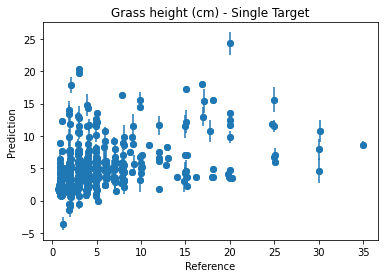

MAE cvr: 5.012086221730485


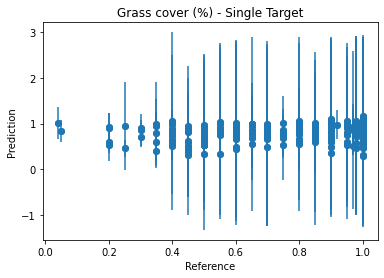

------------------------------------------------------------
------------------------------------------------------------
Trained using: GREEN
MAE hgt: 4.962640824515575


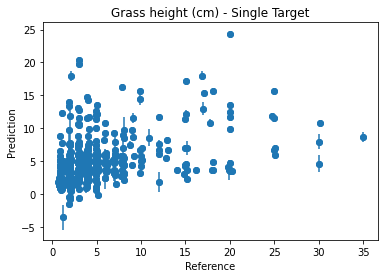

MAE cvr: 4.9613259190443815


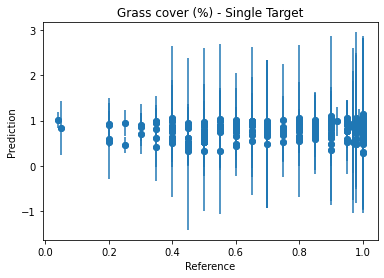

------------------------------------------------------------
------------------------------------------------------------
Trained using: RED
MAE hgt: 4.690992964170201


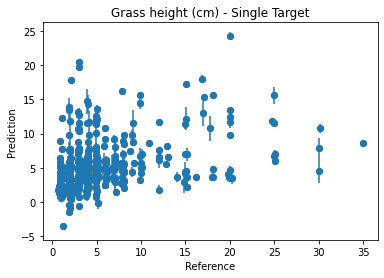

MAE cvr: 5.184351367461422


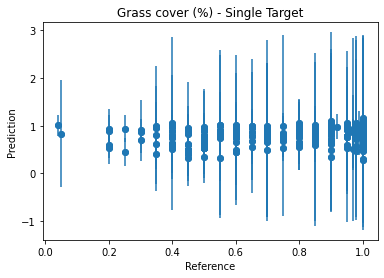

------------------------------------------------------------
------------------------------------------------------------
Trained using: NIR
MAE hgt: 3.8234267682582446


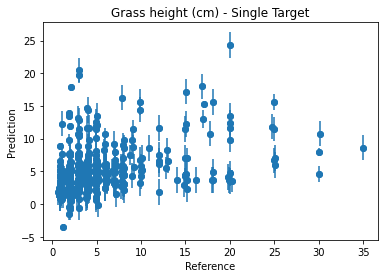

MAE cvr: 4.080210477078164


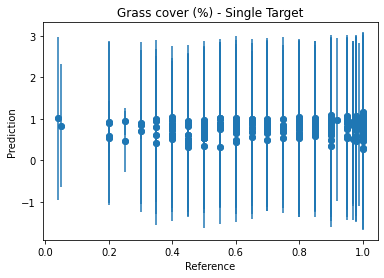

------------------------------------------------------------
------------------------------------------------------------
Trained using: MIR
MAE hgt: 3.7973383315608413


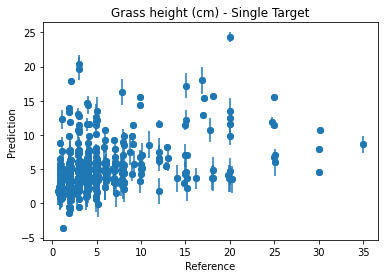

MAE cvr: 3.837952869817318


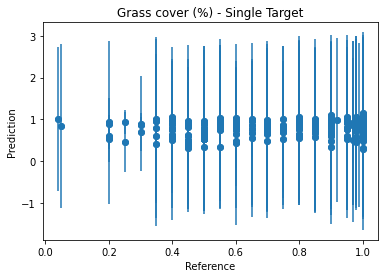

------------------------------------------------------------
------------------------------------------------------------
Trained using: SWIR2
MAE hgt: 3.116457582096757


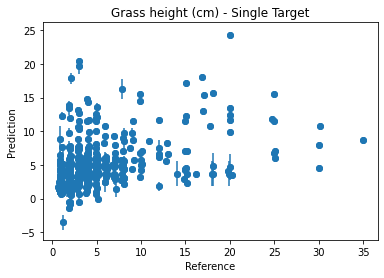

MAE cvr: 4.096494723419439


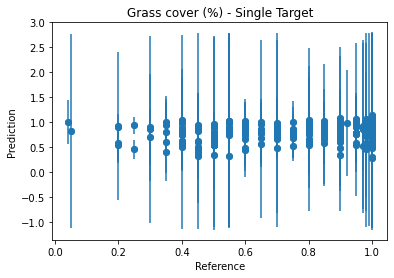

------------------------------------------------------------


In [98]:
#making a numpy of the target variables (validation)
vl_tgt_df = vl_df[[tgt_trait,tgt_trait_2]]
vl_tgt_np = vl_tgt_df.iloc[:,:].values

#making a numpy of the target variables (training)
tr_tgt_df = tr_df[[tgt_trait,tgt_trait_2]]
tr_tgt_np = tr_tgt_df.iloc[:,:].values

for i in feat_names:

  #selecting the feature used for fitting
  var_tmp_df = tr_df[[i]]

  #tranforming to numpy array
  var_tmp_np = var_tmp_df.iloc[:,:].values
  
  #initating the GP
  gpr_mdl_hgt = gpr_call()
  gpr_mdl_cvc = gpr_call()

  #training the GPR
  gpr_mdl_hgt.fit(var_tmp_np,tr_tgt_np[:,0]) #trains on ith variable against the training targets
  gpr_mdl_cvc.fit(var_tmp_np,tr_tgt_np[:,1])

  #selecting feature on the validation dataset and transforming to numpy 
  vl_var_df = vl_df[[i]]
  vl_var_np = vl_var_df.iloc[:,:].values

  #predicting against the validation data
  pred1,sigma = gpr_mdl.predict(vl_var_np,return_std=True) #predicts on the validation dataset
  pred2,sigma = gpr_mdl.predict(vl_var_np,return_std=True) #predicts on the validation dataset

  #the first column is height while the second is cover
  mae_hgt = metrics.mean_absolute_error(vl_tgt_np[:,0], pred1[:,0])
  mae_cvr = metrics.mean_absolute_error(vl_tgt_np[:,1], pred2[:,0])

  #dumping the outputs to the console
  print("------------------------------------------------------------")
  print("Trained using:",i)
  print("MAE hgt:",mae_hgt)
  #plotting height scatterplot
  plt.scatter(vl_tgt_np[:,0], pred[:,0])
  plt.errorbar(vl_tgt_np[:,0],pred[:,0],yerr=1.96*sigma,fmt='o')
  plt.title("Grass height (cm) - Single Target")
  plt.xlabel("Reference")
  plt.ylabel("Prediction")

  # R = np.corrcoef(vl_tgt_np[:,0],pred[:,0])
  # P = np.polyfit(vl_tgt_np[:,0],pred[:,0],1)
  # vmin = np.nanmin([np.min(vl_tgt_np[:,0]), np.min(pred[:,0])])
  # vmax = np.nanmax([np.max(vl_tgt_np[:,0]), np.max(pred[:,0])])
  plt.show()

  print("MAE cvr:",mae_cvr)

  plt.scatter(vl_tgt_np[:,1], pred[:,1])
  plt.errorbar(vl_tgt_np[:,1],pred[:,1],yerr=1.96*sigma,fmt='o')
  plt.title("Grass cover (%) - Single Target")
  plt.xlabel("Reference")
  plt.ylabel("Prediction")
  
  # R = np.corrcoef(vl_tgt_np[:,1],pred[:,1])
  # P = np.polyfit(vl_tgt_np[:,1],pred[:,1],1)
  # vmin = np.nanmin([np.min(vl_tgt_np[:,1]), np.min(pred[:,1])])
  # vmax = np.nanmax([np.max(vl_tgt_np[:,1]), np.max(pred[:,1])])
  plt.show()
  print("------------------------------------------------------------")


 


Combination of specific bands where i expect significant correlations

Multitarget
MAE height: 3.0940005442561325
MAE height: 0.1523721659497301


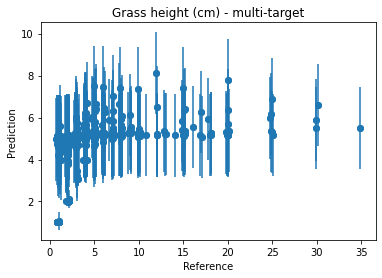

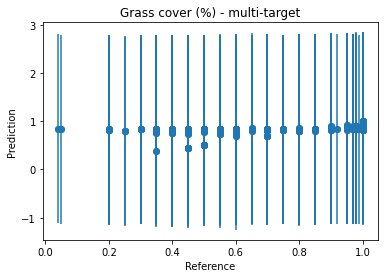

Single target
MAE height: 3.0940005442561325
MAE height: 0.1523721659497301


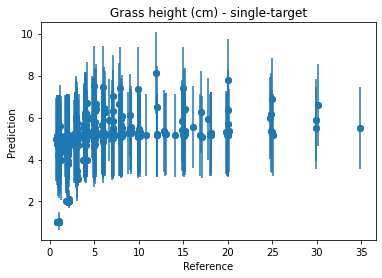

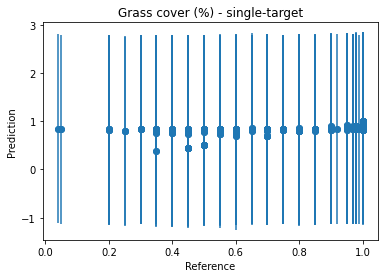

In [97]:
#Variable list for reference
# ["NDVI","EVI","RATIO",
#  "SAVI","TVI","NDWI",
#  "NDTI","RDVI","BLUE",
#  "GREEN","RED","NIR",
#  "MIR","SWIR2"]

#selecting the variables for training
sel_var_tmp_df = tr_df[["BLUE","GREEN","RED","NIR"]]
sel_var_tmp_np = sel_var_tmp_df.iloc[:,:].values

#selecting feature on the validation dataset and transforming to numpy 
sel_vl_var_df = vl_df[["BLUE","GREEN","RED","NIR"]]
sel_vl_var_np = sel_vl_var_df.iloc[:,:].values

#initiating the model object
sel_gpr_mdl = gpr_call()
sel_gpr_mdl_hgt = gpr_call()
sel_gpr_mdl_cvc = gpr_call()

#fitting multi-output
sel_gpr_mdl.fit(sel_var_tmp_np,tr_tgt_np)

#fitting single output
sel_gpr_mdl_hgt.fit(sel_var_tmp_np,tr_tgt_np[:,0])
sel_gpr_mdl_cvc.fit(sel_var_tmp_np,tr_tgt_np[:,1])

#making the predicitons
sel_pred,sel_sigma = sel_gpr_mdl.predict(sel_vl_var_np,return_std=True)
sel_pred_hgt,sel_sigma_hgt = sel_gpr_mdl_hgt.predict(sel_vl_var_np,return_std=True)
sel_pred_cvc,sel_sigma_cvc = sel_gpr_mdl_cvc.predict(sel_vl_var_np,return_std=True)

#error of multi-target
sel_mae_hgt = metrics.mean_absolute_error(vl_tgt_np[:,0], sel_pred[:,0])
sel_mae_cvc = metrics.mean_absolute_error(vl_tgt_np[:,1], sel_pred[:,1])

print("Multitarget")
print("MAE height:",sel_mae_hgt)
print("MAE height:",sel_mae_cvc)

plt.scatter(vl_tgt_np[:,0], sel_pred[:,0])
plt.errorbar(vl_tgt_np[:,0],sel_pred[:,0],yerr=1.96*sel_sigma,fmt='o')
plt.title("Grass height (cm) - multi-target")
plt.xlabel("Reference")
plt.ylabel("Prediction")
plt.show()

plt.scatter(vl_tgt_np[:,1], sel_pred[:,1])
plt.errorbar(vl_tgt_np[:,1],sel_pred[:,1],yerr=1.96*sel_sigma,fmt='o')
plt.title("Grass cover (%) - multi-target")
plt.xlabel("Reference")
plt.ylabel("Prediction")
plt.show()

#error of single target
sel_mae_hgt_st = metrics.mean_absolute_error(vl_tgt_np[:,0], sel_pred_hgt)
sel_mae_cvc_st = metrics.mean_absolute_error(vl_tgt_np[:,1], sel_pred_cvc)

print("Single target")
print("MAE height:",sel_mae_hgt_st)
print("MAE height:",sel_mae_cvc_st)

plt.scatter(vl_tgt_np[:,0], sel_pred_hgt)
plt.errorbar(vl_tgt_np[:,0],sel_pred_hgt,yerr=1.96*sel_sigma_hgt,fmt='o')
plt.title("Grass height (cm) - single-target")
plt.xlabel("Reference")
plt.ylabel("Prediction")
plt.show()

plt.scatter(vl_tgt_np[:,1], sel_pred_cvc)
plt.errorbar(vl_tgt_np[:,1],sel_pred_cvc,yerr=1.96*sel_sigma_cvc,fmt='o')
plt.title("Grass cover (%) - single-target")
plt.xlabel("Reference")
plt.ylabel("Prediction")
plt.show()




#Generating an example image from a landsat raster

In [ ]:
#loading needed packages
!pip install pyrsgis
!pip install rasterio
!pip install pyproj

import os
from pyrsgis import raster

import rasterio
import rasterio.plot
import pyproj
from pyrsgis.convert import changeDimension

In [87]:
ls_data_path = "/content/drive/My Drive/OVP_Grass/Image_data/Vincent/LC08_198023_20150702.tif"

#loading the raster and checking dimensions
ls1,bands = raster.read(ls_data_path)
print(ls1)
print(bands.shape) #the raster has 9 bands by 501 x 590 (not sure wich is the row)

#converting the rasters into a 2D array where the rows represent the pixel cells and the columns the bands
bandByPixel = changeDimension(bands)#/10000. #we have to devide all values by 10k - its a conversion from bits to reflectances
bandByPixel_t = np.transpose(bandByPixel)
print(bandByPixel.shape)
print(bandByPixel_t.shape)
bandByPixel


(7, 334, 393)
(131262, 7)
(7, 131262)


array([[ 625,  701,  907, ...,  211,   79,   52],
       [ 627,  700,  904, ...,  214,   81,   55],
       [ 630,  701,  909, ...,  211,   78,   56],
       ...,
       [ 599,  806, 1215, ..., 2772, 2346, 1984],
       [ 608,  803, 1190, ..., 2957, 2424, 1907],
       [ 446,  600,  969, ..., 3442, 2028, 1443]])

Text(0, 0.5, 'Row #')

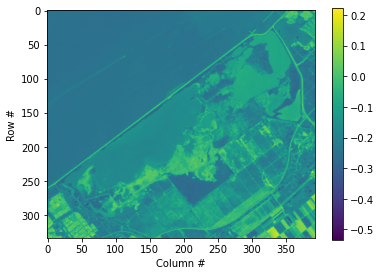

In [115]:
#plotting for exploration

#window = rasterio.windows.Window(1024, 1024, 1280, 2560)

#loads bands into a different object so they can be plotted or NDVI calculated
#notice it opens directly the raster so the division by 10k has to be done again
with rasterio.open(ls_data_path) as src:
  b4 = src.read(4)/10000.
with rasterio.open(ls_data_path) as src:
  b3 = src.read(3)/10000.   

#calculating NDVI
numpy.seterr(divide='ignore', invalid='ignore')
ndvi = (b4.astype(float) - b3.astype(float)) / (b4 + b3)
bandByPixel_ndvi = changeDimension(ndvi)

plt.figure(figsize=(6,8.5))
plt.imshow(ndvi)
#plt.clim(0,1)
plt.colorbar(shrink=0.5)
#plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

#Applying the GP to the data

Might be slow (or fail) if the raster is too big. 

In [116]:
#Predicting with the multiband model
sel_bands = bandByPixel[:,1:5] #selecting B, G, R, NIR
sel_bands.shape

out_img,out_std = sel_gpr_mdl.predict(sel_bands,return_std=True)

In [119]:
#Predicting with only the NDVI
#making a numpy of the target variables (validation)
vl_tgt_df = vl_df[[tgt_trait,tgt_trait_2]]
vl_tgt_np = vl_tgt_df.iloc[:,:].values

#making a numpy of the target variables (training)
tr_tgt_df = tr_df[[tgt_trait,tgt_trait_2]]
tr_tgt_np = tr_tgt_df.iloc[:,:].values

var_tmp_df = tr_df[["NDVI"]]
var_tmp_np = var_tmp_df.iloc[:,:].values

gpr_mdl = gpr_call()
gpr_mdl.fit(var_tmp_np,tr_tgt_np) #trains on ith variable against the training targets

#predicting
out_img,out_std = gpr_mdl.predict(bandByPixel_ndvi.reshape(-1, 1),return_std=True)

Converting back to a raster

Text(0, 0.5, 'Row #')

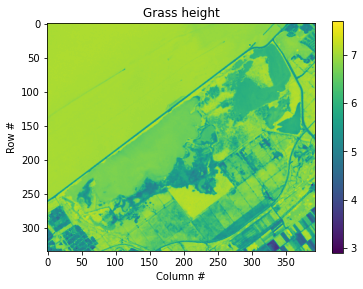

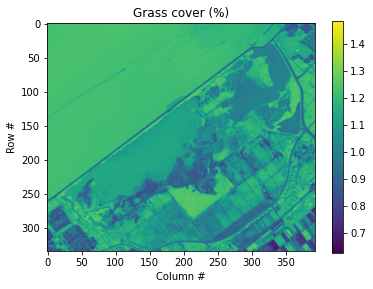

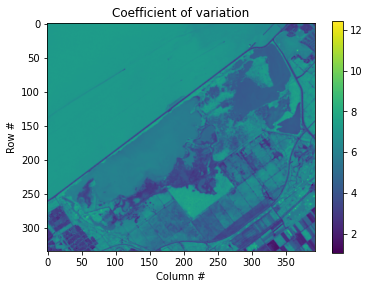

In [122]:
out_img_rst_hgt = np.reshape(out_img[:,0],(ls1.RasterYSize,ls1.RasterXSize))
out_img_rst_cvc = np.reshape(out_img[:,1],(ls1.RasterYSize,ls1.RasterXSize))
out_std_rst = np.reshape(out_std/np.mean(out_img)*100,(ls1.RasterYSize,ls1.RasterXSize))

#in a GIS we can easily change the color scale to avoid the extremes
plt.figure(figsize=(6,8.5))
plt.imshow(out_img_rst_hgt)
plt.colorbar(shrink=0.5)
#plt.clim(0,20)
plt.title('Grass height')
plt.xlabel('Column #')
plt.ylabel('Row #')

#in a GIS we can easily change the color scale to avoid the extremes
plt.figure(figsize=(6,8.5))
plt.imshow(out_img_rst_cvc)
#plt.clim(0,1)
plt.colorbar(shrink=0.5)
plt.title('Grass cover (%)')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.figure(figsize=(6,8.5))
plt.imshow(out_std_rst)
#plt.clim(0,20)
plt.colorbar(shrink=0.5)
plt.title('Coefficient of variation')
plt.xlabel('Column #')
plt.ylabel('Row #')

#saving the rasters to a temporary folder

In [86]:
#raster.export(out_img_rst_hgt, ls1, "grass_height.tif", dtype='float')
raster.export(out_img_rst_cvc, ls1, "grass_cover.tif", dtype='float')